<a href="https://colab.research.google.com/github/IrfanPavel/Transfer-Learning-with-Tensorflow-Feature-Extraction/blob/main/Transfer_Learning_with_Tensorflow(Feature_Extraction).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!nvidia-smi

Thu Apr 21 14:41:06 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Getting great Results with 10% of the data**

In [9]:
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-04-21 14:41:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.128, 64.233.189.128, 108.177.97.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   171MB/s    in 0.9s    

2022-04-21 14:41:08 (171 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [10]:
#How many images in each folder
import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print("There are {} directories and {} images in {}".format(len(dirnames),len(filenames),(dirpath)))

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 10 directori

# **Preparing The Data**

In [11]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [17]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [13]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [18]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [19]:
def create_model(model_url, num_classes=10):

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

# **Now we've got a function for creating a model,we'll use it it to first create a model using  the ResNetV250 architecture as our feature extraction layer**

In [21]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [26]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220421-144638
Epoch 1/5
24/24 [==============================] - 37s 999ms/step - loss: 1.9656 - accuracy: 0.3520 - val_loss: 1.2327 - val_accuracy: 0.6072
Epoch 2/5
24/24 [==============================] - 21s 899ms/step - loss: 0.9473 - accuracy: 0.7267 - val_loss: 0.8771 - val_accuracy: 0.7200
Epoch 3/5
24/24 [==============================] - 21s 897ms/step - loss: 0.6429 - accuracy: 0.8320 - val_loss: 0.7652 - val_accuracy: 0.7468
Epoch 4/5
24/24 [==============================] - 21s 884ms/step - loss: 0.4964 - accuracy: 0.8760 - val_loss: 0.7179 - val_accuracy: 0.7712
Epoch 5/5
24/24 [==============================] - 21s 887ms/step - loss: 0.3960 - accuracy: 0.9147 - val_loss: 0.6926 - val_accuracy: 0.7768


In [22]:
import matplotlib.pyplot as plt
def plot_loss_curves(history):
  loss=history.history["loss"]
  val_loss=history.history["val_loss"]
  accuracy=history.history["accuracy"]
  val_accuracy=history.history["val_accuracy"]
  epochs=range(len(history.history["loss"]))

  #PLOT LOSS

  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()





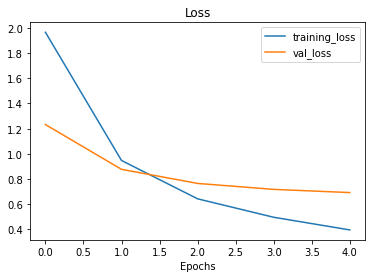

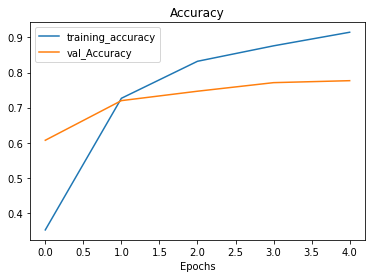

In [27]:
plot_loss_curves(resnet_history)

In [28]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [29]:
#Create A model
efficientnet_model=create_model(model_url=efficientnet_url,
                             num_classes=train_data_10_percent.num_classes)

#Compile Efficient Model
efficientnet_model.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])


#Fit Efficient Model
efficientnet_history=efficientnet_model.fit(train_data_10_percent,
                                            epochs=5,
                                            steps_per_epoch=len(train_data_10_percent),
                                            validation_data=test_data,
                                            validation_steps=len(test_data),
                                            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="efficientnetBO")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetBO/20220421-144942
Epoch 1/5
24/24 [==============================] - 32s 890ms/step - loss: 1.7517 - accuracy: 0.4840 - val_loss: 1.2380 - val_accuracy: 0.7672
Epoch 2/5
24/24 [==============================] - 19s 796ms/step - loss: 1.0040 - accuracy: 0.8027 - val_loss: 0.8288 - val_accuracy: 0.8388
Epoch 3/5
24/24 [==============================] - 18s 790ms/step - loss: 0.7170 - accuracy: 0.8333 - val_loss: 0.6721 - val_accuracy: 0.8532
Epoch 4/5
24/24 [==============================] - 18s 790ms/step - loss: 0.5795 - accuracy: 0.8693 - val_loss: 0.5893 - val_accuracy: 0.8632
Epoch 5/5
24/24 [==============================] - 18s 788ms/step - loss: 0.4924 - accuracy: 0.8893 - val_loss: 0.5420 - val_accuracy: 0.8628


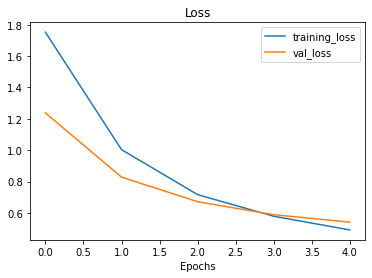

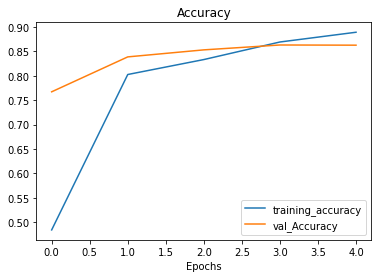

In [30]:
plot_loss_curves(efficientnet_history)